# Building scenarios

Pymagicc offers the ability to join/merge scenarios to create custom scenarios. Here we show a minimal working example of how to do this.

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join
from datetime import datetime

import pandas as pd

from pymagicc import MAGICC6
from pymagicc.io import MAGICCData
from pymagicc.definitions import (
    convert_magicc7_to_openscm_variables, 
    PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1
)

import expectexception

import matplotlib.pyplot as plt
plt.style.use('bmh') 
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
DATA_DIR = join("..", "tests", "test_data")
DATA_MAGICC6_RUN = join("..", "pymagicc", "MAGICC6", "run")

We start by reading in our raw data. As the formats we're reading don't have any easily readable metadata, we set it using the `columns` argument. 

**Note**: The `model` column refers to the model which generated the scenario (typically an integrated assessment model), with the `climate_model` column being saved for storing the climate model which was used to do climate projections.

In [3]:
rcp3pd = MAGICCData(
    join(DATA_DIR, "RCP3PD_EMISSIONS.DAT"),
    columns={
        "model": "IMAGE",
        "scenario": "RCP3PD"
    }
)
rcp3pd.head()

time                                                                                                               1765-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model                  todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    MAGICC6.3.09, 25 November 2009 SET                 0.003   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    MAGICC6.3.09, 25 November 2009 SET                 0.000   
                      Emissions|CH4                              Mt CH4 / yr  MAGICC6.3.09, 25 November 2009 SET                 0.000   
                      Emissions|N2O                              Mt N2ON / yr MAGICC6.3.09, 25 November 2009 SET                 0.000   
                      Emissions|SOx                              Mt S / yr    MAGICC6.3.09, 25 November 2009 SET                 0.000   

time                                                                                                               1766-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model                  todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    MAGICC6.3.09, 25 November 2009 SET              0.003000   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    MAGICC6.3.09, 25 November 2009 SET              0.005338   
                      Emissions|CH4                              Mt CH4 / yr  MAGICC6.3.09, 25 November 2009 SET              1.963262   
                      Emissions|N2O                              Mt N2ON / yr MAGICC6.3.09, 25 November 2009 SET              0.005191   
                      Emissions|SOx                              Mt S / yr    MAGICC6.3.09, 25 November 2009 SET              0.098883   

time                                                                                                               1767-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model                  todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    MAGICC6.3.09, 25 November 2009 SET              0.003000   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    MAGICC6.3.09, 25 November 2009 SET              0.010677   
                      Emissions|CH4                              Mt CH4 / yr  MAGICC6.3.09, 25 November 2009 SET              2.436448   
                      Emissions|N2O                              Mt N2ON / yr MAGICC6.3.09, 25 November 2009 SET              0.010117   
                      Emissions|SOx                              Mt S / yr    MAGICC6.3.09, 25 November 2009 SET              0.116306   

time                                                                                                               1768-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model                  todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    MAGICC6.3.09, 25 November 2009 SET              0.003000   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    MAGICC6.3.09, 25 November 2009 SET              0.016015   
                      Emissions|CH4                              Mt CH4 / yr  MAGICC6.3.09, 25 November 2009 SET              2.911105   
                      Emissions|N2O                              Mt N2ON / yr MAGICC6.3.09, 25 November 2009 SET              0.015043   
                      Emissions|SOx                              Mt S / yr    MAGICC6.3.09, 25 November 2009 SET              0.133811   

time                                                                                                               1769-01-01 00:00:

This data came from MAGICC6.3.09, in order to set it up for a new run, we have to strip out that information.

In [4]:
rcp3pd.set_meta("unspecified", "climate_model")
rcp3pd.head()

time                                                                                              1765-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                 0.003   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                 0.000   
                      Emissions|CH4                              Mt CH4 / yr  unspecified   SET                 0.000   
                      Emissions|N2O                              Mt N2ON / yr unspecified   SET                 0.000   
                      Emissions|SOx                              Mt S / yr    unspecified   SET                 0.000   

time                                                                                              1766-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET              0.003000   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET              0.005338   
                      Emissions|CH4                              Mt CH4 / yr  unspecified   SET              1.963262   
                      Emissions|N2O                              Mt N2ON / yr unspecified   SET              0.005191   
                      Emissions|SOx                              Mt S / yr    unspecified   SET              0.098883   

time                                                                                              1767-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET              0.003000   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET              0.010677   
                      Emissions|CH4                              Mt CH4 / yr  unspecified   SET              2.436448   
                      Emissions|N2O                              Mt N2ON / yr unspecified   SET              0.010117   
                      Emissions|SOx                              Mt S / yr    unspecified   SET              0.116306   

time                                                                                              1768-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET              0.003000   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET              0.016015   
                      Emissions|CH4                              Mt CH4 / yr  unspecified   SET              2.911105   
                      Emissions|N2O                              Mt N2ON / yr unspecified   SET              0.015043   
                      Emissions|SOx                              Mt S / yr    unspecified   SET              0.133811   

time                                                                                              1769-01-01 00:00:00  \
model scenario region variable                                   unit         climate_model todo                        
IMAGE RCP3PD   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET              0.003000   
                      Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET              0.021353   
                      Emissions|CH4                              Mt CH4 / yr  unspecified   SET              3.387278   
   

In [5]:
rcp85 = MAGICCData(
    join(DATA_MAGICC6_RUN, "RCP85.SCEN"),
    columns={
        "model": "MESSAGE",
        "scenario": "RCP85"
    }
)
rcp85.set_meta("unspecified", "climate_model")
rcp85.head()

time                                                                                                       2000-01-01 00:00:00  \
model   scenario region        variable                                   unit         climate_model todo                        
MESSAGE RCP85    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                               Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                0.0000   
                               Emissions|CH4                              Mt CH4 / yr  unspecified   SET                0.4325   
                               Emissions|N2O                              Mt N2ON / yr unspecified   SET                0.0000   
                               Emissions|SOx                              Mt S / yr    unspecified   SET                5.5390   

time                                                                                                       2001-01-01 00:00:00  \
model   scenario region        variable                                   unit         climate_model todo                        
MESSAGE RCP85    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                               Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                0.0000   
                               Emissions|CH4                              Mt CH4 / yr  unspecified   SET                0.4422   
                               Emissions|N2O                              Mt N2ON / yr unspecified   SET                0.0000   
                               Emissions|SOx                              Mt S / yr    unspecified   SET                5.5824   

time                                                                                                       2002-01-01 00:00:00  \
model   scenario region        variable                                   unit         climate_model todo                        
MESSAGE RCP85    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                               Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                0.0000   
                               Emissions|CH4                              Mt CH4 / yr  unspecified   SET                0.4520   
                               Emissions|N2O                              Mt N2ON / yr unspecified   SET                0.0000   
                               Emissions|SOx                              Mt S / yr    unspecified   SET                5.6207   

time                                                                                                       2003-01-01 00:00:00  \
model   scenario region        variable                                   unit         climate_model todo                        
MESSAGE RCP85    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET                0.0000   
                               Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET                0.0000   
                               Emissions|CH4                              Mt CH4 / yr  unspecified   SET                0.4618   
                               Emissions|N2O                              Mt N2ON / yr unspecified   SET                0.0000   
                               Emissions|SOx                              Mt S / yr    unspecified   SET                5.6587   

time                                                                                                       2004-01-01 00:00:00  \
model   scenario region        variable                                   unit         climate_model todo                        
MESSAGE RCP85    World|Bunkers Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecifi

To join the data, we first have to do a little bit of preparation. Specifically, we must make sure that the metadata for the timeseries we want to prepare is the same which means re-writing the model and scenario columns.

In [6]:
my_scen_hist = rcp3pd.copy()
my_scen_hist.set_meta("idealised", "model")
my_scen_hist.set_meta("custom", "scenario")

my_scen_future = rcp85.copy()
my_scen_future.set_meta("idealised", "model")
my_scen_future.set_meta("custom", "scenario")

my_scen_future.tail()

time                                                                              2000-01-01 00:00:00  \
model     scenario region variable           unit             climate_model todo                        
idealised custom   World  Emissions|HFC134a  kt HFC134a / yr  unspecified   SET               75.0394   
                          Emissions|HFC143a  kt HFC143a / yr  unspecified   SET                6.2341   
                          Emissions|HFC227ea kt HFC227ea / yr unspecified   SET                1.9510   
                          Emissions|HFC245fa kt HFC245fa / yr unspecified   SET               17.9257   
                          Emissions|SF6      kt SF6 / yr      unspecified   SET                5.5382   

time                                                                              2001-01-01 00:00:00  \
model     scenario region variable           unit             climate_model todo                        
idealised custom   World  Emissions|HFC134a  kt HFC134a / yr  unspecified   SET               84.0409   
                          Emissions|HFC143a  kt HFC143a / yr  unspecified   SET                7.4947   
                          Emissions|HFC227ea kt HFC227ea / yr unspecified   SET                1.6450   
                          Emissions|HFC245fa kt HFC245fa / yr unspecified   SET               19.7183   
                          Emissions|SF6      kt SF6 / yr      unspecified   SET                5.6990   

time                                                                              2002-01-01 00:00:00  \
model     scenario region variable           unit             climate_model todo                        
idealised custom   World  Emissions|HFC134a  kt HFC134a / yr  unspecified   SET               94.7162   
                          Emissions|HFC143a  kt HFC143a / yr  unspecified   SET                8.7389   
                          Emissions|HFC227ea kt HFC227ea / yr unspecified   SET                2.5080   
                          Emissions|HFC245fa kt HFC245fa / yr unspecified   SET               21.5109   
                          Emissions|SF6      kt SF6 / yr      unspecified   SET                5.8596   

time                                                                              2003-01-01 00:00:00  \
model     scenario region variable           unit             climate_model todo                        
idealised custom   World  Emissions|HFC134a  kt HFC134a / yr  unspecified   SET              101.4157   
                          Emissions|HFC143a  kt HFC143a / yr  unspecified   SET                9.9776   
                          Emissions|HFC227ea kt HFC227ea / yr unspecified   SET                3.3410   
                          Emissions|HFC245fa kt HFC245fa / yr unspecified   SET               23.3034   
                          Emissions|SF6      kt SF6 / yr      unspecified   SET                6.0202   

time                                                                              2004-01-01 00:00:00  \
model     scenario region variable           unit             climate_model todo                        
idealised custom   World  Emissions|HFC134a  kt HFC134a / yr  unspecified   SET              113.9297   
                          Emissions|HFC143a  kt HFC143a / yr  unspecified   SET               11.2136   
                          Emissions|HFC227ea kt HFC227ea / yr unspecified   SET                4.2690   
                          Emissions|HFC245fa kt HFC245fa / yr unspecified   SET               25.0960   
                          Emissions|SF6      kt SF6 / yr      unspecified   SET                6.1806   

time                                                                              2005-01-01 00:00:00  \
model     scenario region variable           unit             climate_model todo                        
idealised custom   World  Emissions|HFC134a  kt HFC134a / yr  unspecified   SET              120.9334   
     

To then join the data, we can simply filter the data and then append one onto the other. 

In [7]:
# NBVAL_IGNORE_OUTPUT
my_scen_hist.filter(year=range(1, 2006)).head()

time                                                                                                  1765-01-01  \
model     scenario region variable                                   unit         climate_model todo               
idealised custom   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET        0.003   
                          Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET        0.000   
                          Emissions|CH4                              Mt CH4 / yr  unspecified   SET        0.000   
                          Emissions|N2O                              Mt N2ON / yr unspecified   SET        0.000   
                          Emissions|SOx                              Mt S / yr    unspecified   SET        0.000   

time                                                                                                  1766-01-01  \
model     scenario region variable                                   unit         climate_model todo               
idealised custom   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET     0.003000   
                          Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET     0.005338   
                          Emissions|CH4                              Mt CH4 / yr  unspecified   SET     1.963262   
                          Emissions|N2O                              Mt N2ON / yr unspecified   SET     0.005191   
                          Emissions|SOx                              Mt S / yr    unspecified   SET     0.098883   

time                                                                                                  1767-01-01  \
model     scenario region variable                                   unit         climate_model todo               
idealised custom   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET     0.003000   
                          Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET     0.010677   
                          Emissions|CH4                              Mt CH4 / yr  unspecified   SET     2.436448   
                          Emissions|N2O                              Mt N2ON / yr unspecified   SET     0.010117   
                          Emissions|SOx                              Mt S / yr    unspecified   SET     0.116306   

time                                                                                                  1768-01-01  \
model     scenario region variable                                   unit         climate_model todo               
idealised custom   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET     0.003000   
                          Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET     0.016015   
                          Emissions|CH4                              Mt CH4 / yr  unspecified   SET     2.911105   
                          Emissions|N2O                              Mt N2ON / yr unspecified   SET     0.015043   
                          Emissions|SOx                              Mt S / yr    unspecified   SET     0.133811   

time                                                                                                  1769-01-01  \
model     scenario region variable                                   unit         climate_model todo               
idealised custom   World  Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr    unspecified   SET     0.003000   
                          Emissions|CO2|MAGICC AFOLU                 Gt C / yr    unspecified   SET     0.021353   
                          Emissions|CH4                              Mt CH4 / yr  unspecified   SET     3.387278   
                          Emissions|N2O                              Mt N2ON / yr unspecified   SET     0.019969   
                          Emissions|SOx             

In [8]:
# NBVAL_IGNORE_OUTPUT
rcp3pd_up_to_2005 = my_scen_hist.filter(year=range(1, 2006))
rcp85_2006_onwards = my_scen_future.filter(year=range(2006, 30000))
# TODO: fix openscm method so it checks for duplicate time points, not duplicate index...
my_scen = rcp3pd_up_to_2005.append(rcp85_2006_onwards, duplicate_msg="warn")
my_scen["time"].head()

0    1765-01-01 00:00:00
1    1766-01-01 00:00:00
2    1767-01-01 00:00:00
3    1768-01-01 00:00:00
4    1769-01-01 00:00:00
Name: time, dtype: object

In [9]:
# NBVAL_IGNORE_OUTPUT
my_scen["time"].tail()

261    2300-01-01 00:00:00
262    2350-01-01 00:00:00
263    2400-01-01 00:00:00
264    2450-01-01 00:00:00
265    2500-01-01 00:00:00
Name: time, dtype: object

Note that appending in this way keeps all of the available data. This means that we still have regional data over the future.

In [10]:
# NBVAL_IGNORE_OUTPUT
my_scen.filter(region="World", keep=False).head()

time                                                                                      2006-01-01 00:00:00  \
model     scenario region        variable                   unit      climate_model todo                        
idealised custom   World|Bunkers Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.0000   
                   World|R5ASIA  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.4317   
                   World|R5LAM   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.3360   
                   World|R5MAF   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.2230   
                   World|R5OECD  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.1197   

time                                                                                      2007-01-01 00:00:00  \
model     scenario region        variable                   unit      climate_model todo                        
idealised custom   World|Bunkers Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.0000   
                   World|R5ASIA  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.4182   
                   World|R5LAM   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.3315   
                   World|R5MAF   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.2188   
                   World|R5OECD  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.1136   

time                                                                                      2010-01-01 00:00:00  \
model     scenario region        variable                   unit      climate_model todo                        
idealised custom   World|Bunkers Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.0000   
                   World|R5ASIA  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.3776   
                   World|R5LAM   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.3177   
                   World|R5MAF   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.2060   
                   World|R5OECD  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.0951   

time                                                                                      2020-01-01 00:00:00  \
model     scenario region        variable                   unit      climate_model todo                        
idealised custom   World|Bunkers Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.0000   
                   World|R5ASIA  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.2973   
                   World|R5LAM   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.3379   
                   World|R5MAF   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.1955   
                   World|R5OECD  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                0.0436   

time                                                                                      2030-01-01 00:00:00  \
model     scenario region        variable                   unit      climate_model todo                        
idealised custom   World|Bunkers Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                 0.000   
                   World|R5ASIA  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                 0.191   
                   World|R5LAM   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                 0.328   
                   World|R5MAF   Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                 0.186   
                   World|R5OECD  Emissions|CO2|MAGICC AFOLU Gt C / yr unspecified   SET                -0.012   

time                                    

We can remove this by simply filtering our scenario once again.

In [11]:
# NBVAL_IGNORE_OUTPUT
my_scen_world = my_scen.filter(region="World")
my_scen_world.head()

time                                                                                                 1765-01-01 00:00:00  \
model     scenario region variable                                   unit        climate_model todo                        
idealised custom   World  Emissions|CO2|MAGICC AFOLU                 Gt C / yr   unspecified   SET                 0.000   
                          Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   unspecified   SET                 0.003   
                          Emissions|BC                               Mt BC / yr  unspecified   SET                 0.000   
                          Emissions|CH4                              Mt CH4 / yr unspecified   SET                 0.000   
                          Emissions|CO                               Mt CO / yr  unspecified   SET                 0.000   

time                                                                                                 1766-01-01 00:00:00  \
model     scenario region variable                                   unit        climate_model todo                        
idealised custom   World  Emissions|CO2|MAGICC AFOLU                 Gt C / yr   unspecified   SET              0.005338   
                          Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   unspecified   SET              0.003000   
                          Emissions|BC                               Mt BC / yr  unspecified   SET              0.106998   
                          Emissions|CH4                              Mt CH4 / yr unspecified   SET              1.963262   
                          Emissions|CO                               Mt CO / yr  unspecified   SET              9.050221   

time                                                                                                 1767-01-01 00:00:00  \
model     scenario region variable                                   unit        climate_model todo                        
idealised custom   World  Emissions|CO2|MAGICC AFOLU                 Gt C / yr   unspecified   SET              0.010677   
                          Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   unspecified   SET              0.003000   
                          Emissions|BC                               Mt BC / yr  unspecified   SET              0.133383   
                          Emissions|CH4                              Mt CH4 / yr unspecified   SET              2.436448   
                          Emissions|CO                               Mt CO / yr  unspecified   SET             12.960844   

time                                                                                                 1768-01-01 00:00:00  \
model     scenario region variable                                   unit        climate_model todo                        
idealised custom   World  Emissions|CO2|MAGICC AFOLU                 Gt C / yr   unspecified   SET              0.016015   
                          Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   unspecified   SET              0.003000   
                          Emissions|BC                               Mt BC / yr  unspecified   SET              0.159847   
                          Emissions|CH4                              Mt CH4 / yr unspecified   SET              2.911105   
                          Emissions|CO                               Mt CO / yr  unspecified   SET             16.876539   

time                                                                                                 1769-01-01 00:00:00  \
model     scenario region variable                                   unit        climate_model todo                        
idealised custom   World  Emissions|CO2|MAGICC AFOLU                 Gt C / yr   unspecified   SET              0.021353   
                          Emissions|CO2|MAGICC Fossil and Industrial Gt C / yr   unspecified   SET              0.003000   
                          Em

We can check the results as shown.

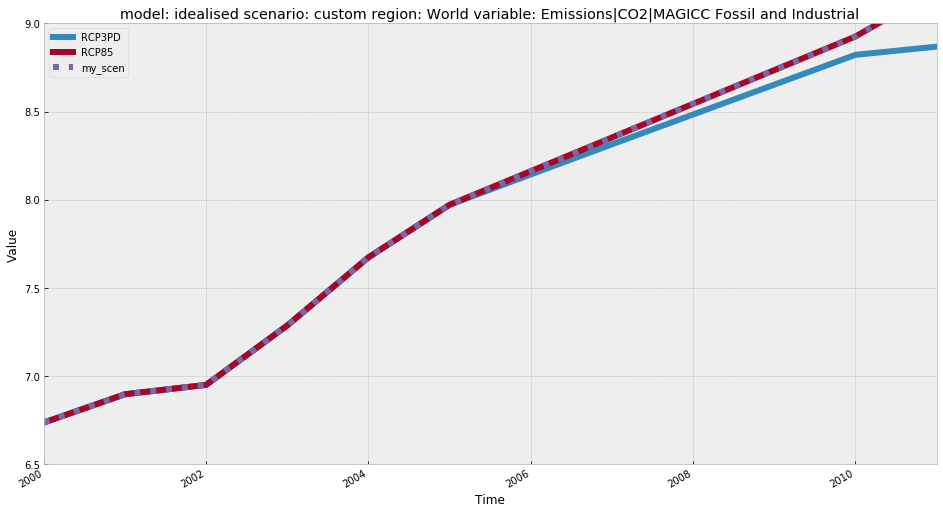

In [12]:
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

ax = rcp3pd.filter(
    variable=var_to_plot,
    region="World"
).line_plot(x="time", label="RCP3PD", lw=6.0, figsize=(16, 9))
rcp85.filter(
    variable=var_to_plot,
    region="World"
).line_plot(x="time", label="RCP85", lw=6.0, ax=ax)
my_scen_world.filter(
    variable=var_to_plot
).line_plot(x="time", label="my_scen", lw=6.0, linestyle=":", ax=ax)
ax.set_xlim([datetime(2000, 1, 1), datetime(2011, 1, 1)])
ax.set_ylim([6.5, 9]);

If we put our scenario into a MAGICCData object, we can run it using Pymagicc.

Note that Pymagicc automatically only uses the variables which are in SCEN files.

In [13]:
with MAGICC6() as magicc:
    results = magicc.run(my_scen_world)

/home/jupyter-znicholls/pymagicc/pymagicc/io.py:1823: UserWarning: Ignoring input data which is not required for .SCEN file
  warnings.warn("Ignoring input data which is not required for .SCEN file")


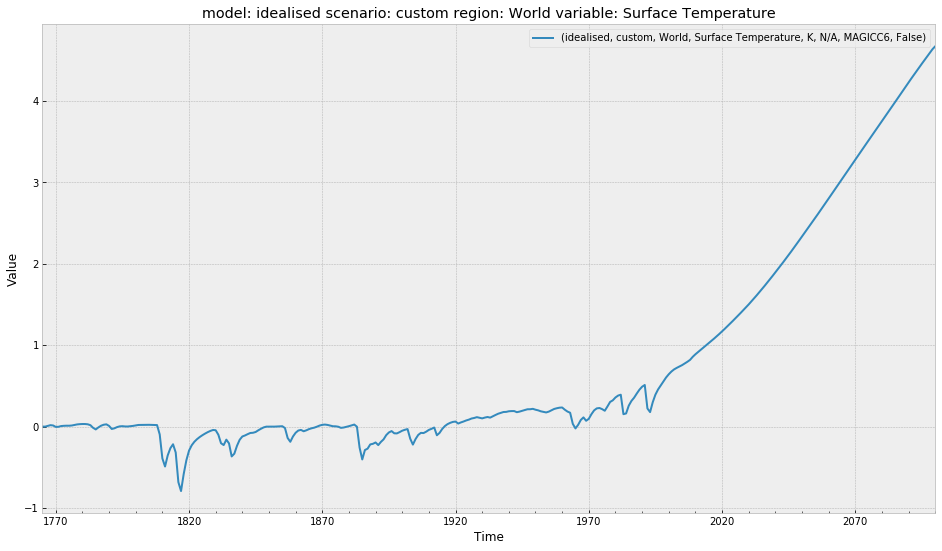

In [14]:
results.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time", figsize=(16, 9));

If we wish, we can also `MAGICCData`'s resample method to join our timeseries together with a linear interpolation over a given period. This allows us to use some base scenario, overwrite with a multitude of other scenarios but ensure they all have a common historical period and some roughly smooth transition. (At the moment the `resample` and `interpolate` methods are the only options, a far more complete solution would be to use the [Aneris](https://github.com/iiasa/aneris) package but this would also be far more difficult.)

In [15]:
rcp3pd_up_to_2005 = my_scen_hist.filter(year=range(1, 2006))
rcp85_2015_onwards = my_scen_future.filter(year=range(2015, 30000))
# TODO: fix openscm method so it checks for duplicate time points, not duplicate index...
# TODO: work out why resample and interpolate are so slow...
target_times = [datetime(y, 1, 1) for y in range(2000, 2501)]
linear_scen = rcp3pd_up_to_2005.append(
    rcp85_2015_onwards, duplicate_msg="warn"
).filter(region="World")#.interpolate(target_times)

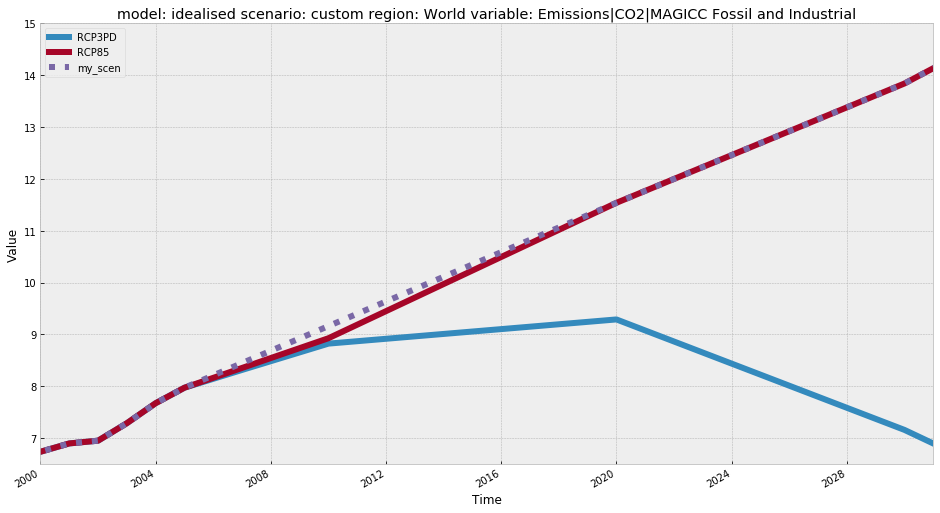

In [16]:
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

ax = rcp3pd.filter(
    variable=var_to_plot,
    region="World"
).line_plot(x="time", label="RCP3PD", lw=6.0, figsize=(16, 9))
rcp85.filter(
    variable=var_to_plot,
    region="World"
).line_plot(x="time", label="RCP85", lw=6.0, ax=ax)
linear_scen.filter(
    variable=var_to_plot
).line_plot(x="time", label="my_scen", lw=6.0, linestyle=":", ax=ax)
ax.set_xlim([datetime(2000, 1, 1), datetime(2031, 1, 1)])
ax.set_ylim([6.5, 15]);

In [17]:
with MAGICC6() as magicc:
    results = magicc.run(linear_scen)

/home/jupyter-znicholls/pymagicc/pymagicc/io.py:1823: UserWarning: Ignoring input data which is not required for .SCEN file
  warnings.warn("Ignoring input data which is not required for .SCEN file")


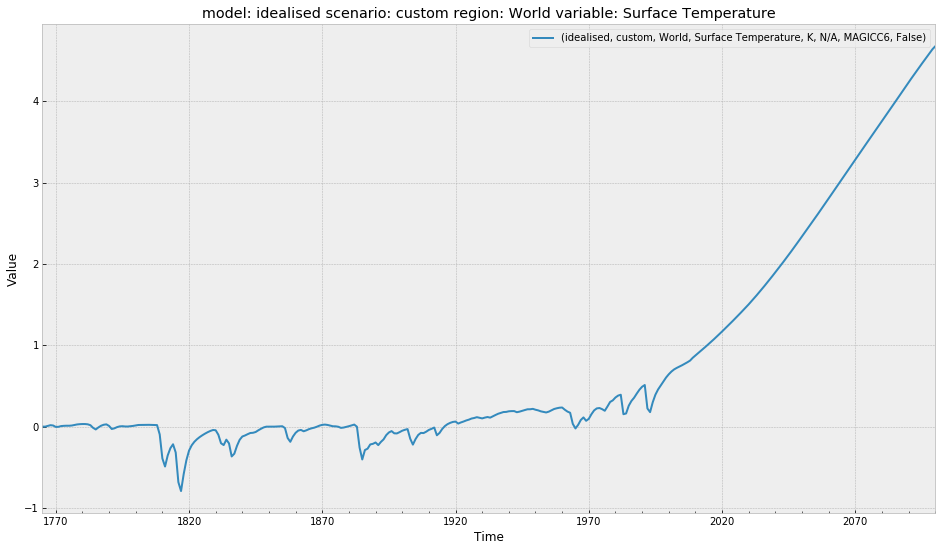

In [18]:
results.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time", figsize=(16, 9));

## Warning

If you try to merge data which has no overlapping indices, you'll end up with `np.nan` in your output. For example, if we set our "todo" column to "N/A" in `base` (for an explanation of what this "todo" column is, see [file conventions](https://pymagicc.readthedocs.io/en/latest/file_conventions.html#columns)).

As a user, you have to check carefully that the merging has actually happened as intended (pull requests with convenience functions that can help automate these checks are most welcome!!). One easy way to do this is to simply see if any of the data in the output is null.

In [19]:
rcp85_2015_onwards_world = my_scen_future.filter(
    year=range(2015, 30000), 
    region="World",
)
rcp3pd_up_to_2005_world = my_scen_hist.filter(
    year=range(1, 2006), 
    region="World",
)

null_output = rcp3pd_up_to_2005_world.append(rcp85_2015_onwards_world, duplicate_msg="warn").timeseries()
null_output.isnull().any().any()

True

There are still null values, we can see where they are with something like this.

In [20]:
null_output[null_output.isnull().any(axis=1)]

time                                                                                1765-01-01 00:00:00  \
model     scenario region variable            unit              climate_model todo                        
idealised custom   World  Emissions|CCl4      kt CCl4 / yr      unspecified   SET                 0.000   
                          Emissions|CFC11     kt CFC11 / yr     unspecified   SET                 0.000   
                          Emissions|CFC113    kt CFC113 / yr    unspecified   SET                 0.000   
                          Emissions|CFC114    kt CFC114 / yr    unspecified   SET                 0.000   
                          Emissions|CFC115    kt CFC115 / yr    unspecified   SET                 0.000   
                          Emissions|CFC12     kt CFC12 / yr     unspecified   SET                 0.000   
                          Emissions|CH3Br     kt CH3Br / yr     unspecified   SET               157.267   
                          Emissions|CH3CCl3   kt CH3CCl3 / yr   unspecified   SET                 0.000   
                          Emissions|CH3Cl     kt CH3Cl / yr     unspecified   SET              3100.211   
                          Emissions|HCFC141b  kt HCFC141b / yr  unspecified   SET                 0.000   
                          Emissions|HCFC142b  kt HCFC142b / yr  unspecified   SET                 0.000   
                          Emissions|HCFC22    kt HCFC22 / yr    unspecified   SET                 0.000   
                          Emissions|Halon1202 kt Halon1202 / yr unspecified   SET                 0.000   
                          Emissions|Halon1211 kt Halon1211 / yr unspecified   SET                 0.000   
                          Emissions|Halon1301 kt Halon1301 / yr unspecified   SET                 0.000   
                          Emissions|Halon2402 kt Halon2402 / yr unspecified   SET                 0.000   

time                                                                                1766-01-01 00:00:00  \
model     scenario region variable            unit              climate_model todo                        
idealised custom   World  Emissions|CCl4      kt CCl4 / yr      unspecified   SET                 0.000   
                          Emissions|CFC11     kt CFC11 / yr     unspecified   SET                 0.000   
                          Emissions|CFC113    kt CFC113 / yr    unspecified   SET                 0.000   
                          Emissions|CFC114    kt CFC114 / yr    unspecified   SET                 0.000   
                          Emissions|CFC115    kt CFC115 / yr    unspecified   SET                 0.000   
                          Emissions|CFC12     kt CFC12 / yr     unspecified   SET                 0.000   
                          Emissions|CH3Br     kt CH3Br / yr     unspecified   SET               157.267   
                          Emissions|CH3CCl3   kt CH3CCl3 / yr   unspecified   SET                 0.000   
                          Emissions|CH3Cl     kt CH3Cl / yr     unspecified   SET              3100.211   
                          Emissions|HCFC141b  kt HCFC141b / yr  unspecified   SET                 0.000   
                          Emissions|HCFC142b  kt HCFC142b / yr  unspecified   SET                 0.000   
                          Emissions|HCFC22    kt HCFC22 / yr    unspecified   SET                 0.000   
                          Emissions|Halon1202 kt Halon1202 / yr unspecified   SET                 0.000   
                          Emissions|Halon1211 kt Halon1211 / yr unspecified   SET                 0.000   
                          Emissions|Halon1301 kt Halon1301 / yr unspecified   SET                 0.000   
                          Emissions|Halon2402 kt Halon2402 / yr unspecified   SET                 0.000   

time                                                                                1767-01-01 00:00:00  \
model     scenario region variable     

This makes it clear that all of the non-SCEN gases have `np.nan` values into the future, which makes sense as the SCEN file does not define them. 

If we drop these variables first, i.e. do the merge carefully, none of the null values appear.

In [21]:
rcp85_2015_onwards_world = my_scen_future.filter(year=range(2015, 30000), region="World")
rcp3pd_up_to_2005_world_careful = my_scen_hist.filter(
    year=range(1, 2006), 
    region="World",
    variable=rcp85_2015_onwards_world["variable"],
)

no_nulls = rcp3pd_up_to_2005_world_careful.append(rcp85_2015_onwards_world, duplicate_msg="warn")
no_nulls.timeseries().isnull().any().any()

False

As a side effect, running MAGICC with this scenario does not produce any warning about ignoring data.

In [22]:
with MAGICC6() as magicc:
    results = magicc.run(linear_scen)